In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import multiprocessing
from transformers import DistilBertTokenizer, DistilBertModel, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelWithLMHead, AutoModel
from tqdm.notebook import tqdm
from common import Common, Timer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import random
from apex import amp

In [2]:
PATH = 'C:/Users/bill/Documents/projects/data/chatbot'
MAX_WORKERS = multiprocessing.cpu_count() - 1
B = 32
E = 10
T = 500
Y = 199

In [3]:
train_df = pd.read_csv(os.path.join(PATH, 'train.tsv'), sep='\t')[['utterance', 'intent']].dropna().reset_index(drop=True)
valid_df = pd.read_csv(os.path.join(PATH, 'valid.tsv'), sep='\t')[['utterance', 'intent']].dropna().reset_index(drop=True)

intents = LabelEncoder()
intents.fit(pd.concat([ train_df['intent'], valid_df['intent'] ]))
train_df['intent'] = intents.transform(train_df['intent'])
valid_df['intent'] = intents.transform(valid_df['intent'])

# to ensure that BERT will run without problem on sequence length
train_df['utterance'] = train_df['utterance'].apply(lambda x : x[:T])
valid_df['utterance'] = valid_df['utterance'].apply(lambda x : x[:T])
    
itrain = Common.generator(train_df['utterance'], train_df['intent'], B)
ivalid = Common.generator(valid_df['utterance'], valid_df['intent'], B)

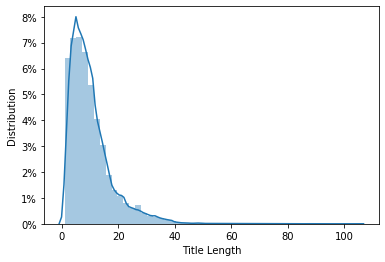

In [4]:
x = pd.concat([train_df['utterance'], valid_df['utterance']])
ax = sns.distplot(x.str.split().apply(len))
ax.set(xlabel='Title Length', ylabel='Distribution')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
plt.show()

In [5]:
class Model(nn.Module):
    
    #model = 'distilbert-base-cased'
    def __init__(self, model, T, Y, device, L=0):
        super(Model, self).__init__()
        self.T = T
        self.device = device
        #self.tokenizer = DistilBertTokenizer.from_pretrained(
        #    os.path.join(PATH, 'tokenizer'), do_lower_case=True)
        #self.model = DistilBertModel.from_pretrained(
        #    os.path.join(PATH, 'distilBERT')).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model, do_lower_case=True)
        self.model = AutoModel.from_pretrained(model)
        # remove layers
        for _ in range(L):
            self.model.transformer.layer.__delitem__(0)
        self.linear = nn.Linear(768, Y)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, inputs):
        tokens = self.tokenizer.batch_encode_plus(
            inputs, 
            add_special_tokens=True, 
            return_tensors='pt', 
            pad_to_max_length=True,
            #max_length=self.T,
            return_attention_masks=False
        )['input_ids'].to(self.device)
        #with torch.no_grad():
        output = self.model(tokens)[0][:,0,:]
        #output = torch.flatten(output, start_dim=1)
        output = self.dropout(output)
        output = self.linear(output)
        return output
    
def scoring(device, model, criterion, iterator):
    with torch.no_grad():
        total_loss = []
        total_accy = []
        for x, y in iterator:
            scores = model(x)
            loss = criterion(scores, y.to(device).long())
            total_loss.append(loss.item())
            total_accy.append(Common.accuracy(scores, y, device))
    return np.mean(total_loss), np.mean(total_accy)

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [8]:
lr = 2e-5 #[2e-5, 3e-5, 4e-5, 5e-5]:

device = Common.device()
# 
L = 0
model = Model('distilbert-base-uncased', T, Y, device, L).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('num of params: {}'.format(num_params))

optimizer = AdamW(model.parameters(),
    lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
    weight_decay = 0.01
)

opt_level = 'O2'
model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)

criterion = Common.criterion()
#criterion = FocalLoss(device)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 1, # Default value in run_glue.py
    num_training_steps = len(itrain) * E)

#schedular = CosineAnnealingLR(optimizer, T_max=2)

seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

best_loss = 999
best_model = None
best_epoch = 0

for epoch in range(E):
    t = Timer()
    total_loss = []
    total_accy = []
    for x, y in tqdm(itrain):

        # step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # step 3. Run our forward pass.
        scores = model(x)

        # step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(scores, y.to(device).long())
        total_loss.append(loss.item())
        #total_accy.append(sum(torch.argmax(scores, axis=1) == y.to(device)).true_divide(len(y)).item())
        total_accy.append(Common.accuracy(scores, y, device))

        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
            
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    train_loss, train_accy = np.mean(total_loss), np.mean(total_accy)
    valid_loss, valid_accy = scoring(device, model, criterion, ivalid)

    if valid_loss < best_loss:
        Common.save_checkpoint({
            'loss': valid_loss,
            'accuracy': valid_accy,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, './models/model.tar')
        best_model = model
        best_epoch = epoch
        best_loss = valid_loss

    print(', '.join([
        'epoch: {}'.format(epoch),
        'train_loss: {:3.2}'.format(train_loss),
        'valid_loss: {:3.2}'.format(valid_loss),
        'train_accy: {:3.2%}'.format(train_accy),
        'valid_accy: {:3.2%}'.format(valid_accy),
        'time: {}'.format(t.get())
    ]))

# test_loss, test_accy = scoring(device, best_model, criterion, itest)
# Log.info(', '.join([
#         'best_epoch: {}'.format(best_epoch),
#         'test_loss: {:3.2}'.format(test_loss),
#         'test_accy: {:3.2}'.format(test_accy)
#     ]))

num of params: 66515911
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0

epoch: 0, train_loss: 1.5, valid_loss: 1.0, train_accy: 70.12%, valid_accy: 77.05%, time: 00:03:21


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0

epoch: 1, train_loss: 0.46, valid_loss: 0.92, train_accy: 88.98%, valid_accy: 77.77%, time: 00:03:20


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0

epoch: 2, train_loss: 0.25, valid_loss: 0.96, train_accy: 94.02%, valid_accy: 78.17%, time: 00:03:20



epoch: 3, train_loss: 0.12, valid_loss: 0.97, train_accy: 97.19%, valid_accy: 79.04%, time: 00:03:18


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0

epoch: 4, train_loss: 0.062, valid_loss: 1.0, train_accy: 98.77%, valid_accy: 79.13%, time: 00:03:20


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0

epoch: 5, train_loss: 0.031, valid_loss: 1.1, train_accy: 99.46%, valid_accy: 78.94%, time: 00:03:18


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0

epoch: 6, train_loss: 0.017, valid_loss: 1.1, train_accy: 99.73%, valid_accy: 78.90%, time: 00:03:18


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0

epoch: 7, train_loss: 0.01, valid_loss: 1.1, train_accy: 99.85%, valid_accy: 79.20%, time: 00:03:18



epoch: 8, train_loss: 0.0058, valid_loss: 1.2, train_accy: 99.92%, valid_accy: 79.00%, time: 00:03:19


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0

epoch: 9, train_loss: 0.004, valid_loss: 1.2, train_accy: 99.94%, valid_accy: 79.20%, time: 00:03:19


In [ ]:
model = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model, do_lower_case=True)
model = AutoModel.from_pretrained(model)

In [ ]:
device = torch.device('cpu')
cp = torch.load('./models/model.tar', map_location=device)
model = Model('distilbert-base-uncased', T, Y, device, L).to(device)
optimizer = AdamW(model.parameters(),
    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)
#criterion = FocalLoss(device)
criterion = Common.criterion()
#qmodel = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
model.load_state_dict(cp['state_dict'])
optimizer.load_state_dict(cp['optimizer'])

#torch.set_num_threads(1)

In [ ]:
import datetime

total = []
_start = datetime.datetime.now()
for i, x in enumerate(valid_df['utterance'].values):
    start = datetime.datetime.now()
    with torch.no_grad():
        scores = model([x])
    delta = datetime.datetime.now() - start
    total.append(delta.total_seconds() * 1000)
    if i % 500 == 0 and i > 0:
        print((datetime.datetime.now() - _start).total_seconds())
        _start = datetime.datetime.now()

In [ ]:
np.mean(total)

In [ ]:
x = valid_df['utterance'].str.split().map(len).values
y = np.array(total)

sns.set(color_codes=True)
ax = sns.regplot(x, y, marker='+', color='b')
ax.set(xlabel='# of tokens', ylabel='elapsed time (millisecond)')

import scipy
slope, intercept, r2, p_value, std_err = scipy.stats.linregress(x=x, y=y)
print(f'line-fit: y = {round(intercept, 2)} + {round(slope, 2)} x')
print(f'r2: {round(r2 ** 2, 2)}')

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
tokenizer.vocab_size

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer.encode('my cat ate my card.'))

In [ ]:
inputs = [
    'change of address but not effective till 9 / 22',
    'my cat sucks really bad',
    'my day is going well',
    'Here is the sentence I want embeddings for.'
]
tokens = tokenizer.batch_encode_plus(
    inputs, 
    add_special_tokens=True, 
    return_tensors='pt', 
    pad_to_max_length=True,
    max_length=50,
    return_attention_masks=False
)

print(tokens)

#for token in tokens:
#    print(tokenizer.convert_ids_to_tokens(token))
# tokens = []
# for x in inputs:
#     tokens.append(torch.tensor(tokenizer.encode(x, add_special_tokens=True, max_length=T, pad_to_max_length=True)))
    
# tokens = torch.stack(tokens).to(device)
# _, output = model(**tokens)
#output = torch.flatten(output, start_dim=1)